# Drift Example using a GPU
This will only work on systems that support the GPU based method, which is not available in all GPT versions.

In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

# Distgen

In [2]:
from pmd_beamphysics import ParticleGroup
from distgen import Generator

DISTGEN_FILE_STR="""
n_particle: 20000
species: electron
random:
    type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
total_charge:
  units: nC
  value: 1
r_dist:
  sigma_xy:
    units: mm
    value: 1.0
  type: radial_gaussian
z_dist:
  avg_z:
    units: mm
    value: 0
  sigma_z:
    units: mm
    value: 0.1
  type: gaussian
transforms:
  t1:
    avg_pz: 
      value: 10
      units: MeV/c
    type: set_avg pz
"""

gen = Generator(DISTGEN_FILE_STR,verbose=False)
gen.run()

<ParticleGroup with 20000 particles at 0x14d98f8f0>

# Run GPT (CPU)

In [3]:
GPT_FILE="""
setfile("beam", "gpt_particles.gdf");
time=0.0;

auto_phase=0.0;
space_charge=0.0;
cathode=0.0;
space_charge_type=1.0;
RadiusMax=0.04;
GBacc=5.5;
xacc=6.5;
accuracy(GBacc, xacc);
dtmin=1e-16;
dtmax=1e-10;
 
Alpha=1.0;
Fn=0.5;
verror=0.005;
Nstd=5.0;
tree_code_theta=1.0;
tree_code_R=1e-06;
if (space_charge == 1) {

    if (space_charge_type == 1) {
        if(cathode == 1) {
            spacecharge3Dmesh("Cathode", "MeshNfac", Alpha, "MeshAdapt", Fn, "SolverAcc", verror, "MeshBoxSize", Nstd);
        } else {
            spacecharge3Dmesh("MeshNfac", Alpha, "MeshAdapt", Fn, "SolverAcc", verror, "MeshBoxSize", Nstd);
        }
    }
    if (space_charge_type == 2) {
        setrmacrodist("beam","u",tree_code_R,0) ;
        spacecharge3Dtree(tree_code_theta) ;   }
        
    if (space_charge_type == 3) {
        spacechargeP2Pgpu("3D", "SinglePrecision");
        }
}
Ntout=50.0;
tmax=10e-9;
ZSTART=-0.005;
ZSTOP=3;
zminmax("wcs", "I", ZSTART, ZSTOP);

if(Ntout>0) {
    tout(time, tmax, tmax/Ntout);
}
"""

with open('gpt.gpu.test.in', 'w') as fid:
    fid.write(GPT_FILE)

In [4]:
from gpt import GPT

drift = 1

settings = {
    'space_charge': 1,
    'space_charge_type': 1, # CPU
    'Alpha': 1.0,
    'Fn':  0.1,
    'verror':  0.005,
    'Nstd':  12,
    'Ntout': 10,
    'tmax': 1.8*drift/3e8,
    'ZSTOP':drift
}

G = GPT(input_file='gpt.gpu.test.in', initial_particles=gen.particles, verbose=True)
G.set_variables(settings)
G

   Initial 20000 particles written to "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpbn8guv2s/gpt.particles.gdf"
GPT.configure_gpt:
   Original input file "gpt.gpu.test.in" in "/Users/colwyngulliford/GitHub/lume-gpt/examples"
   Configured to run in "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpbn8guv2s"


In [5]:
%%time
G.run()

GPT.run_gpt:
   Initial 20000 particles written to "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpbn8guv2s/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpbn8guv2s/gpt.gpu.test.in"
   Running with timeout = None sec.
   Loading GPT data from /var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmpbn8guv2s/gpt.gpu.test.out.gdf
   GDF data loaded, time ellapsed: 0.0193143 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 10.505 (sec)
CPU times: user 92.2 ms, sys: 18.7 ms, total: 111 ms
Wall time: 10.5 s


tout z-pos: 0.538922870773007


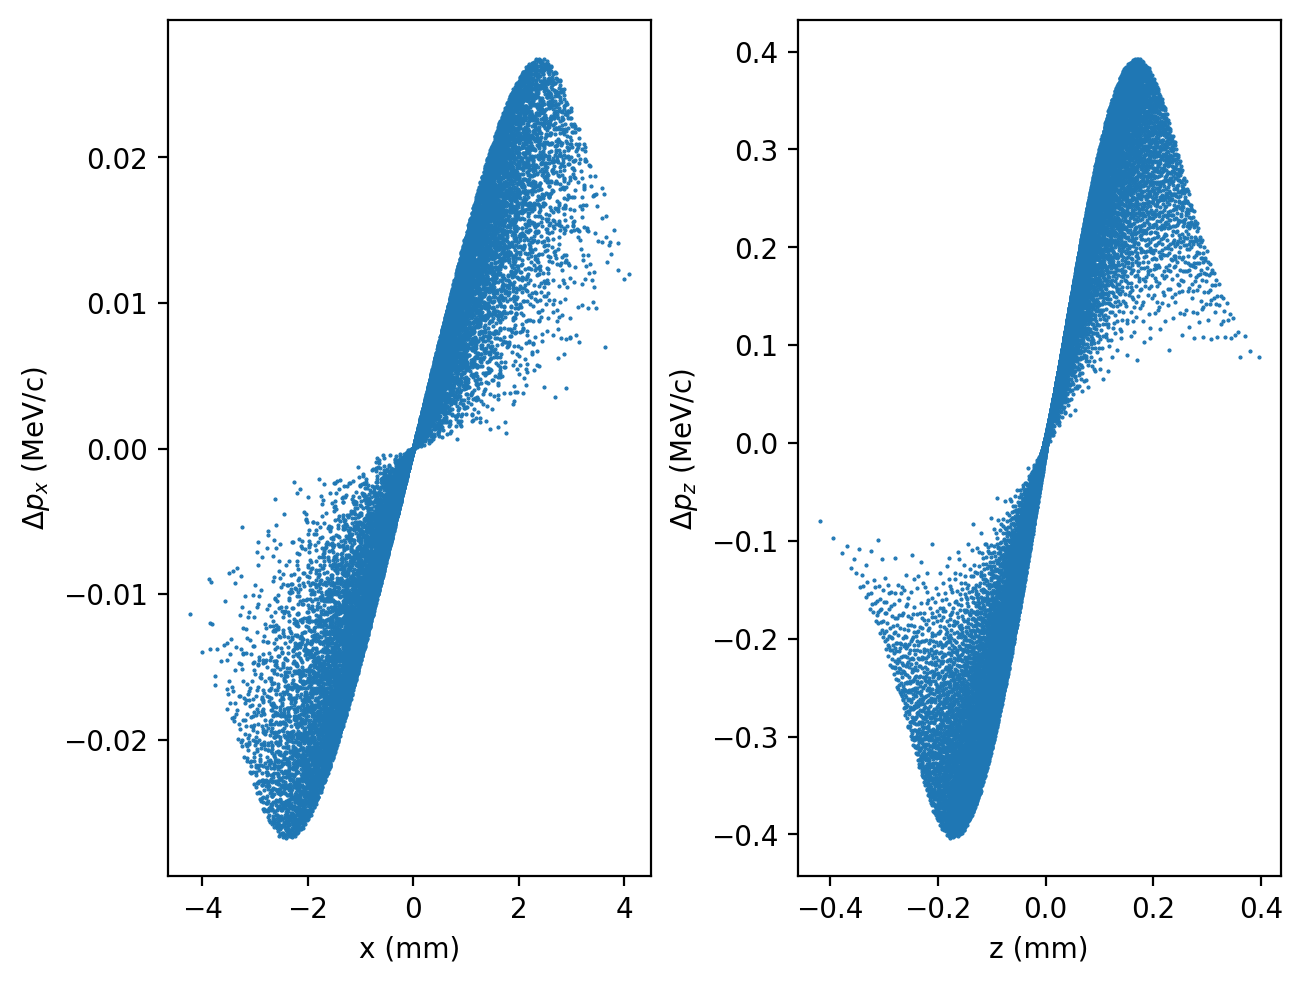

In [6]:
import numpy as np

fig, ax = plt.subplots(1,2, constrained_layout=True)

Pf = G.tout[-3]
print('tout z-pos:',np.mean(Pf['z']))

ax[0].plot(Pf['x']*1000, Pf['delta_px']/1e6, '.', markersize=1)
ax[0].set_xlabel('x (mm)')
ax[0].set_ylabel(r'$\Delta p_x$ (MeV/c)');

ax[1].plot(Pf['delta_z']*1000, Pf['delta_pz']/1e6, '.', markersize=1)
ax[1].set_xlabel('z (mm)')
ax[1].set_ylabel(r'$\Delta p_z$ (MeV/c)');

# GPU method

In [7]:
G2 = G.copy()
G2.set_variable('space_charge_type', 3)

True

In [8]:
%%time
G2.run()

   Initial 20000 particles written to "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmp5td_qwnx/gpt.particles.gdf"
GPT.configure_gpt:
   Original input file "gpt.gpu.test.in" in "/Users/colwyngulliford/GitHub/lume-gpt/examples"
   Configured to run in "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmp5td_qwnx"
GPT.run_gpt:
   Initial 20000 particles written to "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmp5td_qwnx/gpt.particles.gdf"
   Running GPT...
   Writing gpt input file to "/var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmp5td_qwnx/gpt.gpu.test.in"
   Running with timeout = None sec.
   Loading GPT data from /var/folders/jf/c053b9m10035hkwq4wd3bzhr0000gn/T/tmp5td_qwnx/gpt.gpu.test.out.gdf
   GDF data loaded, time ellapsed: 0.00764084 (sec).
   Converting tout and screen data to ParticleGroup(s)
   Run finished, total time ellapsed: 4.42183 (sec)
CPU times: user 144 ms, sys: 21.3 ms, total: 165 ms
Wall time: 4.53 s


# Compare

In [9]:
P1 = G.tout[-1]
P2 = G2.tout[-1]
P1['mean_z'], P2['mean_z']

(0.8982040826690051, 0.898205439649701)

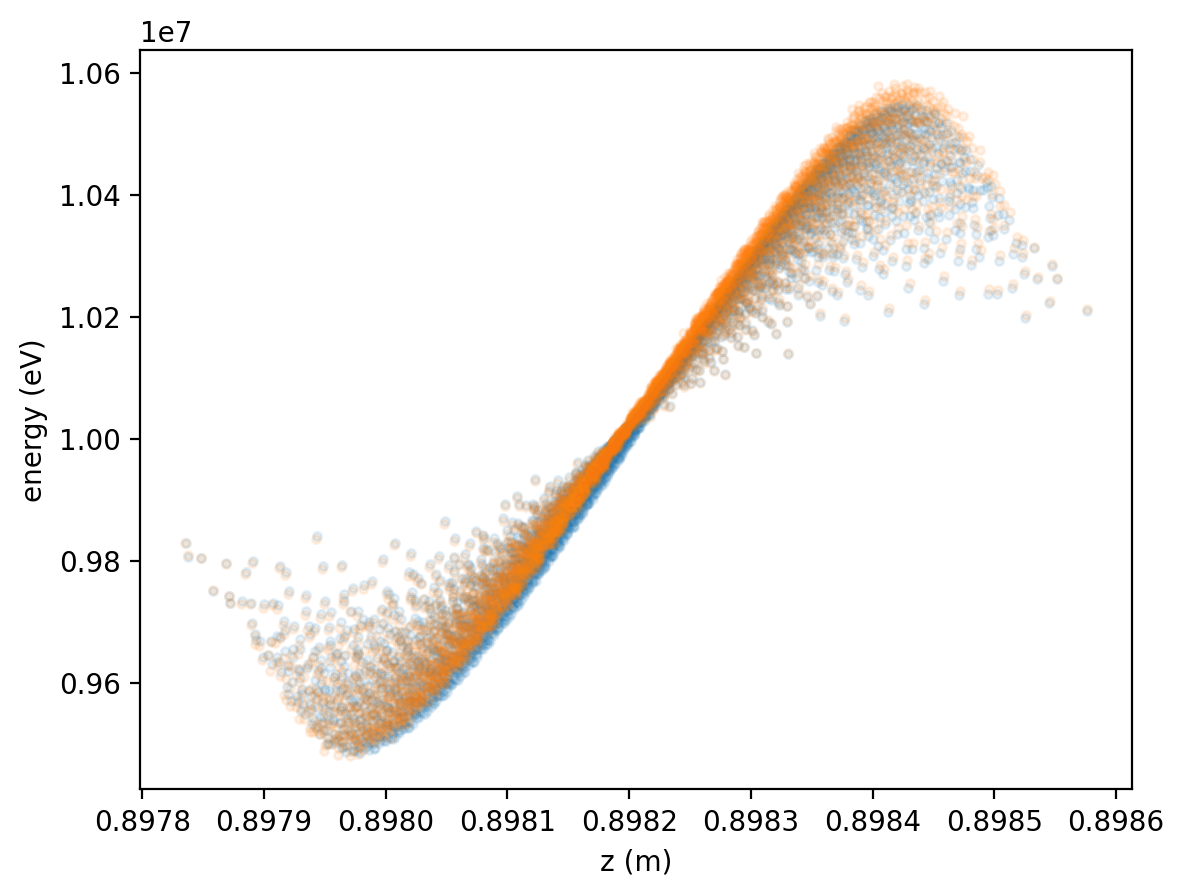

In [10]:
def compare(key1, key2, *plist):
    fig, ax = plt.subplots()
    for pg in plist:
        ax.scatter(pg[key1], pg[key2], marker='.', alpha=0.1)
    ax.set_xlabel(fr'{key1} ({pg.units(key1)})')
    ax.set_ylabel(fr'{key2} ({pg.units(key2)})')
compare('z', 'energy', P1[::5], P2[::5])

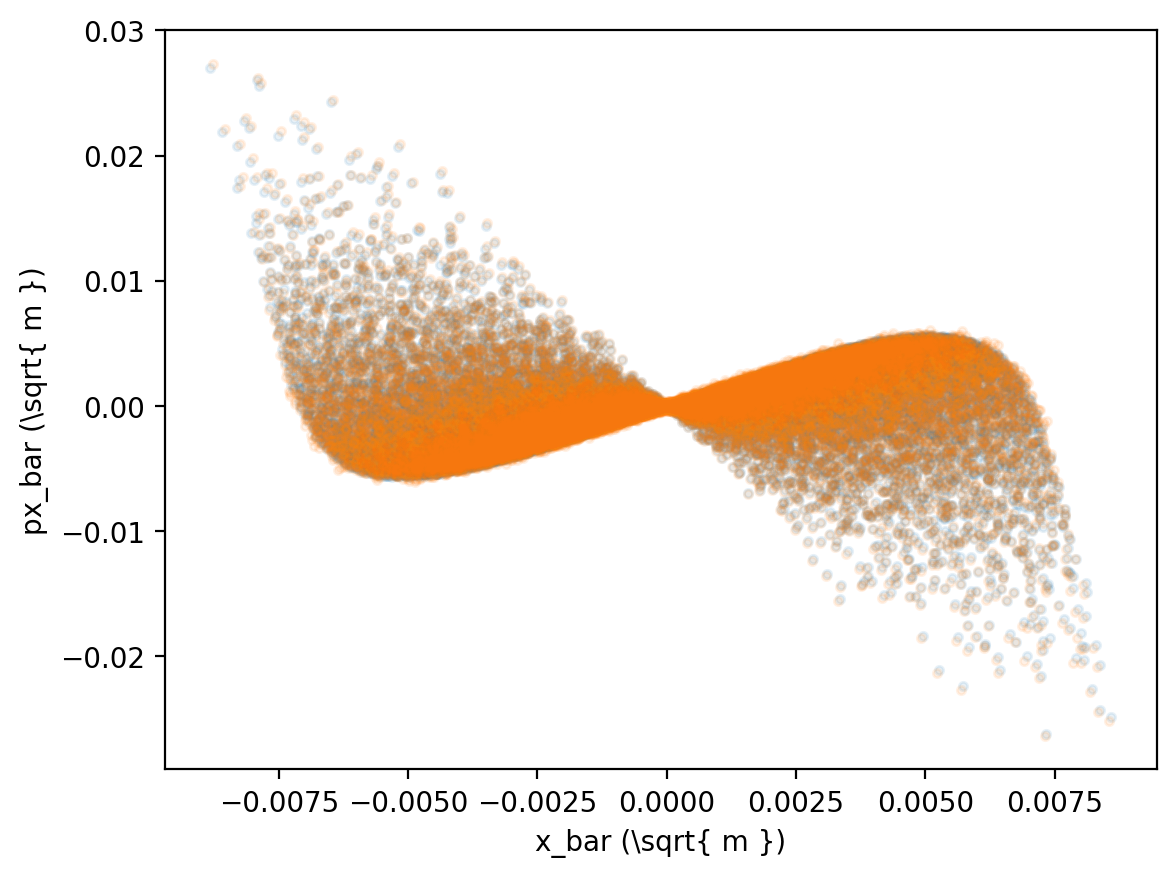

In [11]:
compare('x_bar', 'px_bar', P1[::1], P2[::1])

# Clean up

In [12]:
import os
os.remove('gpt.gpu.test.in');